In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

def profit(quantity, price, cost):
    return (quantity * price) - cost

def remove_low_sales(df, min_count = 50):
    "remove items with sales less than minimum"
    eligible_items = list((df['item_id'].value_counts() < min_count).index)
    return df[df['item_id'].isin(eligible_items)]

def create_random_cost(df,item_id,mu=75,sigma=5):
    "create randomized item cost rate"
    #item_list = df['item_id'].unique()
    #random_cost = np.random.normal(mu, sigma, len(item_list))
    #return pd.DataFrame(zip(item_list,random_cost),columns=['item_id','cost'])
    np.random.seed(1)
    #rate_cost = np.random.randint(60,80,size=1)/100
    rate_cost = 0.83
    print(rate_cost)
    mean_price = df[df['item_id'] == item_id]['item_price'].mean()
    return (rate_cost * mean_price)

In [228]:
sales_raw = pd.read_csv('raw_data/sales_train.csv')
sales = sales_raw.copy()
sales = sales[sales['item_cnt_day'] != -1]
sales['date'] = pd.to_datetime(sales['date'],dayfirst=True)
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['date_2'] = sales['date'].dt.strftime('%Y-%m')

select_shop_id = 31 # top observations
select_item_id = 4181 # top observations
sales = sales[sales['shop_id'] == select_shop_id]
item_cost = create_random_cost(sales, select_item_id)
sales = sales[sales['item_id'] == select_item_id]
sales = sales.drop(['shop_id','item_id'],axis=1)

0.83


# Analisar a curva de oferta x demanda

In [229]:
#sales_agg = sales[sales['year'] == 2013].copy()
sales_agg = sales.copy()
sales_agg = sales_agg.groupby('date_2').agg({'item_cnt_day' : ['sum'], 'item_price' : ['mean']})
sales_agg.columns = ["_".join(x) for x in sales_agg.columns]

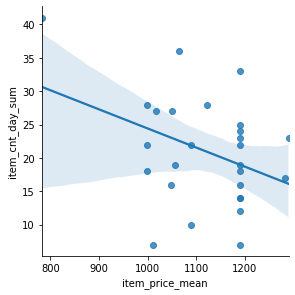

In [230]:
sns.lmplot(x = 'item_price_mean', y = 'item_cnt_day_sum', data = sales_agg, height = 4)

# Estimar a função de demanda

In [231]:
from sklearn.linear_model import LinearRegression

def estimate_demand_function(x,y):
    "basic estimate demand function using OLS"
    length = len(x)
    reg = LinearRegression().fit(x.values.reshape(length, 1), y.values.reshape(length, 1))
    return reg#[reg.intercept_[0],reg.coef_[0][0]]

est_quantity = estimate_demand_function(sales_agg['item_price_mean'],sales_agg['item_cnt_day_sum'])

# Gráfico de preço x lucro

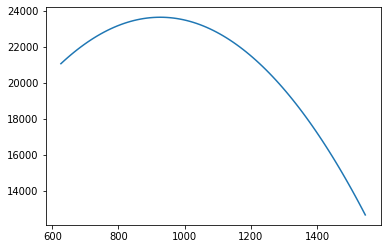

In [232]:
def set_price_range(x):
    minimum_price = x.min()*0.8
    maximum_price = x.max()*1.2
    return range(round(minimum_price), round(maximum_price), 10)

price_range = set_price_range(sales_agg['item_price_mean'])
cost = item_cost
Profit = []

for price_i in price_range:
    quantity_demanded = est_quantity.predict(np.array(price_i).reshape(1, -1))   
    Profit.append(profit(quantity_demanded, price_i, cost))

df_profit = pd.DataFrame({"Price": price_range, "Profit": Profit})
plt.plot(df_profit["Price"], df_profit["Profit"])

In [233]:
# lucro preço x lucro máximo
max_idx = df_profit['Profit'].sort_values(ascending=False).index[0]
df_profit.iloc[max_idx,:]

Price                       926
Profit    [[23651.34315294664]]
Name: 30, dtype: object

# Cálcular o estoque de segurança

In [421]:
# product variables
select_price = 1000
estimate_demand = est_quantity.predict(np.array(select_price).reshape(1, -1))
mean_demand = sales_agg['item_cnt_day_sum'].mean()
std_demand = sales_agg['item_cnt_day_sum'].var()
print(f'est_demand : {estimate_demand} \n mean_demand: {mean_demand} \n std_demand: {std_demand}')
# supply variables
mean_lead_time = 70 # 0.5 * 30 = 15 days
std_lean_time = 10 #  0.2 * 30 = 6 days
# tolerance variable
stock_tolerance = 0.6

est_demand : [[24.4183054]] 
 mean_demand: 21.037037037037038 
 std_demand: 67.65242165242165


In [422]:
def calculate_security_stock(tolerance, mean_lead, std_lead, mean_demand, std_demand):
    return st.norm.ppf(tolerance) * np.sqrt(((std_lead * deviation_multiplier) * mean_lead) + ( (std_demand * deviation_multiplier) * mean_demand))

security_stock =  calculate_security_stock(stock_tolerance,
                                           mean_lead_time,
                                           std_lean_time,
                                           estimate_demand,
                                           std_demand)
security_stock

array([[12.2865705]])

# Cálcular o estoque mínimo e máximo

In [418]:
confidence_tolerance = 0.95
#scipy.stats.poisson.ppf([1-confidence_tolerance, confidence_tolerance], mean_demand)
minimum_stock, max_stock = st.t.interval(confidence_tolerance, len(sales_agg), loc=mean_demand, scale=np.sqrt(std_demand)+2)
if minimum_stock < 1:
    minimum_stock = 1
print(minimum_stock, max_stock)

1 42.01722816542123
